# Analyizing AirBnB's Boston Housing Dataset

In this notebook, we will be exploring AirBnB's Boston Housing dataset, and attempting to answer three distinct questions:

1. Do prices generally concentrate more around the location (city, neighborhood) of a listing or the amenities and features of that listing?

2. How correlated are comments/reviews of a listing with the scores obtained by that listing? 

3. How useful are the axes of data given for each listing in predicting the price of each listing?

### Preliminary Data Exploration

Before beginning to answer these questions, we need to look at the data more in depth.

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline 

In [2]:
# Import data
bos_list = pd.read_csv('../Data/boston_listings.csv') # Listing data
bos_rev = pd.read_csv('../Data/boston_reviews.csv') # Review data

In [3]:
# Inspect column values
bos_list.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bath

From the above list of columns, we can see that a lot of them are not useful for answering any of our questions because they simply do not contribute to the variance of the listing prices. 

For instance, because we know that the data is all from Boston, we do not require the 'market' or 'state' columns, which respectively contain 'Boston' and 'MA' throughout all rows. 'Country_code' is not useful, either, for the same reason.  

'City', however, is not removed. This is because the values it contains actually differ from simply 'Boston' (as it will be seen further on) and can therefore be used to glean more information from the data

In [4]:
# Extract columns to be kept
cols = ['id', 'host_since', 'host_is_superhost', 'host_total_listings_count', 
           'neighbourhood', 'city', 'property_type', 'room_type', 'accommodates', 
           'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 
           'square_feet', 'price', 'guests_included', 
           'first_review', 'last_review', 'review_scores_rating', 
           'review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication',
           'review_scores_location', 'review_scores_value']
bos_list = bos_list[cols]

In [5]:
# Examine column datay types
bos_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 26 columns):
id                             3585 non-null int64
host_since                     3585 non-null object
host_is_superhost              3585 non-null object
host_total_listings_count      3585 non-null int64
neighbourhood                  3042 non-null object
city                           3583 non-null object
property_type                  3582 non-null object
room_type                      3585 non-null object
accommodates                   3585 non-null int64
bathrooms                      3571 non-null float64
bedrooms                       3575 non-null float64
beds                           3576 non-null float64
bed_type                       3585 non-null object
amenities                      3585 non-null object
square_feet                    56 non-null float64
price                          3585 non-null object
guests_included                3585 non-null int64
first_revie

As we can see above, the price is currently interpreted as a string (object). Therefore, we need to change this whole column to be able to compute statistics from it. This can be done by removing the dollar sign and the commas separating the thousands (fullstops are interpreted properly by Python in 'float64', and can be kept).

In [6]:
# Change price from string to float
bos_list['price'] = bos_list['price'].apply(lambda price: float(price[1:].replace(",", "")))

### Question 1:

##### Do prices generally concentrate more around the amenities and features of a listing (such as room_type, etc.) or its location (city, neighborhood)?

For this question, only the first DataFrame (bos_list) is necessary. To answer this question, we can group the listings by their 'city' in one DF and by their 'amenities' and other features in another. We can then compute their descriptive statistics on 'price', and see whether the standard deviations are relatively larger for the 'city' or the 'amenities' and other features. This will tell us where prices vary less (are more concentrated).

##### 1.1 Amenities

To answer this question, we can begin by inspecting the 'amenities' and column of the data.

In [7]:
# Check amenities
bos_list.amenities.value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                                                        32
{TV,"Cable TV","Wireless Internet","Air Conditioning",Kitchen,Heating,Washer,Dryer,"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                                                                                                                                                                                                                             15
{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Gym,"Elevator in Building","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke

The 'amenities' column contains a dictionary for each listing. This makes it rather complicated to consider it a categorical variable because we don't know which dictionary is better than the other. 

Knowing that AirBnB lets hosts tick the amenities they offer off of a standard list, we can safely assume that all hosts have the possibility of choosing the same amenities. Therefore, we can infer that those whose properties include more amenities are better. 

Knowing this, we can clean up this column by simply counting the amenities that each listing has and creating a column for that count. The 'amenities' column can then be dropped. 

In [8]:
# Create new column to count amenities
bos_list['num_amenities'] = bos_list['amenities'].apply(lambda listing: str(listing).count(',') + 1 )
bos_list.drop(['amenities'], inplace=True, axis=1)

# Inspect
bos_list['num_amenities'].head(4)

0    15
1    21
2    18
3    23
Name: num_amenities, dtype: int64

##### 1.2 Features

We can now examine the remaining features of each listing. 

In [9]:
# Examine listing features
features = ['property_type', 'room_type', 'accommodates', 
           'bathrooms', 'bedrooms', 'beds', 'bed_type', 'num_amenities', 
           'square_feet']

# Inspect
bos_list[features].head(4)

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,num_amenities,square_feet
0,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,15,NaN
1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,21,NaN
2,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,18,NaN
3,House,Private room,4,1.0,1.0,2.0,Real Bed,23,NaN


It seems like square_feet is missing a lot of values. We can compute what percentage exactly it is missing to determine whether we should try to fill these values or simply drop the column:

In [10]:
# Examine percentage of NaNs in square_feet
print('Missing:', (1 - bos_list.square_feet.count() / bos_list.shape[0]) * 100, '% of data')

Missing: 98.43793584379358 % of data


The figure is evidently small. Furthermore, attempting to impute these values would be disastrous because each listing is granularly different and there is no way we can obtain nearly-factual data for this variable. It can be dropped.

In [11]:
# Drop square_feet due to low relevance and impossibility of imputation
bos_list.drop(['square_feet'], inplace=True, axis=1)

Now we can examine the property_type variable:

In [12]:
# Examine property types
bos_list['property_type'].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

There are a lot of property types, evidently. However, the vast majority of listings seem to be apartments. Can we glean more information from this data about prices?

In [13]:
# Examine how well the property types bring together price ranges
bos_list.groupby(by='property_type')['price'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Guesthouse,1.0,289.000000,NaN,289.0,289.00,289.0,289.00,289.0
Boat,12.0,268.833333,77.754665,175.0,209.00,262.5,292.50,425.0
Other,17.0,229.941176,143.438345,40.0,130.00,218.0,300.00,500.0
Condominium,231.0,190.246753,122.218815,30.0,104.00,160.0,234.50,700.0
Villa,6.0,189.500000,142.131981,40.0,77.50,170.0,275.25,400.0
Loft,39.0,185.410256,103.999170,30.0,110.00,166.0,245.00,500.0
Apartment,2612.0,181.966692,154.323177,10.0,99.00,159.0,229.00,4000.0
Townhouse,54.0,149.037037,126.163261,44.0,75.00,99.0,170.00,700.0
House,562.0,131.599644,131.121033,20.0,65.00,84.5,140.00,1300.0


As it can be seen, the descriptive statistics offer unclear guidance on how this data could be used. For instance, we can see that 'Guesthouse' has a high mean price, but that's because there is only one listing for that kind of property type. Moreover, since there are so many apartments, we cannot be sure that the mean price for that group is representative of anything since the apartment prices vary so much according to their quality.

The relevance of property types is therefore difficult to quantify - we don't know the square footage of the property in question and therefore cannot deduce how much better or worse, say, a given apartment is to a cottage. Because of this lack of clarity, the variable can also be dropped. 

Let's now examine 'room_type'.

In [14]:
# Examine how well the room types bring together price ranges
bos_list.groupby(by='room_type')['price'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,2127.0,227.436765,157.852765,11.0,150.0,199.0,269.0,4000.0
Private room,1378.0,96.041364,85.093706,10.0,62.0,80.0,100.0,1400.0
Shared room,80.0,92.762500,108.733822,20.0,45.0,60.0,99.0,750.0


Contrary to property_type, 'room_type' does offer relatively straightforward information because it is simple to infer on the relative quality of the room_types. For instance, it is relatively easy to agree on the fact that a private room is better than a shared one, and that an entire apartment is better than a private room. This is precisely what the mean prices above reveal. We can therefore keep this variable.

Let's now examine 'bed_type'.

In [15]:
# Examine how well the bed types bring together price ranges
bos_list.groupby(by='bed_type')['price'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
bed_type,,,,,,,,
Real Bed,3453.0,177.203301,149.712186,10.0,89.00,150.0,225.00,4000.0
Pull-out Sofa,31.0,101.612903,54.262128,35.0,68.50,80.0,114.50,250.0
Couch,10.0,99.600000,59.673556,22.0,64.75,100.0,122.50,225.0
Futon,51.0,85.254902,40.607311,28.0,56.00,75.0,99.00,200.0
Airbed,40.0,78.675000,82.029822,29.0,34.75,45.0,96.25,500.0


Again, it is also relatively easy to agree on the fact that a real bed is better than other kinds of beds. We can therefore also glean more information from this variable, and can keep it. 

To be able to work with 'room_type' and 'bed_type' as features, it would be best to transform them into numeric variables (in the same way we transformed 'amenities' into a numeric variable), since most of the other features ('bathrooms', 'bedrooms', etc.) are also numeric features. 

To do this, we can simply map the unique values of each column to a number. I have decided on arbitrary valuations for each kind of room and bed, following the principle that:
    
    'Entire home/apt' > 'Private room' > 'Shared room' 
    'Real Bed' > 'Pull-Out Sofa' > 'Couch' > 'Futon' > 'Airbed'

As long as the valuations chosen abide by these inequalities, the numbers in the valuations are irrelevant. This is because we are interested in the general relationship that these features have with price (i.e. better room_type = higher price), and not whether the exact value of a room type determines price. 

This study could be improved by conducting a survey to determine how different guests value different kinds of rooms or beds, or otherwise obtaining more accurate numeric values for each of these features. Presently, we will proceed with the valuations detailed below.

In [16]:
# Map room types to room values
room_values = {'Entire home/apt': 25, 'Private room': 10, 'Shared room': 1}
bos_list['room_type_value'] = bos_list['room_type'].apply(lambda value: room_values[value])


# Map bed types to bed values
bed_values = {'Real Bed': 25,'Pull-out Sofa': 10,'Couch': 1,'Futon': 1,'Airbed': 1}
bos_list['bed_type_value'] = bos_list['bed_type'].apply(lambda value: bed_values[value])

We can now drop the columns that were deemed irrelevant above:

    1. square_feet
    2. property_type

In [17]:
# Re-define features by dropping the irrelevant columns and changing 'room_type' and 'bed_type' to their numeric values
features = ['room_type_value', 'accommodates', 'bathrooms', 
            'bedrooms', 'beds', 'bed_type_value', 'num_amenities']

##### 1.3 Aggregating Amenities and Features

Because most of the listing features are numeric ('bathrooms', 'bedrooms', etc.), we previously converted 'amenities', 'room_type', and 'bed_type' (categorical) into numeric features: 'num_amenities', 'room_type_value', and 'bed_type_value', respectively.

Now, to determine the total value of a listing's features and amenities, we can simply add all these variables up into one figure. This can be done as follows:

In [18]:
# Define aggregator function
def sum_features_amenities(listing):
    '''
    INPUT:
        - listing: Record (row) of DataFrame
    
    OUTPUT:
        - value: Aggregation of number of features for each listing
        
    Iterates over different features of each listing and 
    sums the value for each feature to compute a total
    feature value.
    '''
    value = 0
    for feature in features:
        value = value + listing[feature]
    return value

# Aggregate
bos_list['feat_amen_total'] = bos_list.apply(sum_features_amenities, axis = 1)

##### 1.4 City

In [19]:
# Examine variation of price according to city
bos_list.groupby(by=['city'])['price'].mean()

city
ALLSTON                      165.000000
Allston                       73.250000
Boston                       176.789116
Boston                        65.000000
Boston (Charlestown)         200.000000
Boston (Jamaica Plain)        75.000000
Boston, Massachusetts, US     50.000000
Brighton                     108.400000
Brighton                      90.000000
Brookline                    135.888889
Cambridge                    199.375000
Charlestown                  262.533333
Dorchester                    75.466667
East Boston                  134.666667
Hyde Park                     77.500000
Jamaica Plain                178.055556
Jamaica Plain                 68.500000
Jamaica Plain (Boston)       150.000000
Jamaica Plain, Boston        119.000000
Jamaica Plain, MA            120.000000
Jamaica plain                125.000000
Mattapan                      85.000000
Milton                        50.000000
Mission Hill, Boston          85.000000
Newton                        90.00

As we can see in above, the 'city' column is extremely dirty, with multiple string values pointing to a single real-life location. We need to clean this up before continuing:

In [20]:
# Define cleaning function
def city_cleaner(listing):
    '''
    INPUT:
        - listing: Record (row) of DataFrame
        
    OUTPUT:
        - string: Cleaned name of city to which each listing belongs
        
    Transforms the 'city' value of each listing to lowercase,
    and looks for presence of messy city names in each value. 
    It then returns the corresponding, 'clean' value of 'city'
    for each listing.
    '''
    # To lowercase
    listing = listing['city'].lower()
    
    # Turn 'messy' values into 'clean' values
    if 'allston' in listing:
        return 'Allston'
    elif 'boston' in listing or '波士顿' in listing: 
        return 'Boston'
    elif 'brighton' in listing:
        return 'Brighton'
    elif 'dorchester' in listing:
        return 'Dorchester'
    elif 'east boston' in listing:
        return 'East Boston'
    elif 'jamaica plain' in listing:
        return 'Jamaica Plain'
    elif 'roslindale' in listing:
        return 'Roslindale'
    elif 'roxbury' in listing:
        return 'Roxbury'
    elif 'south' in listing:
        return 'South Boston'

In [21]:
# Clean up the city column
bos_list['city'] = bos_list['city'].fillna('Boston')
bos_list['city'] = bos_list.apply(city_cleaner, axis=1)

# Inspect
bos_list.groupby(by=['city'])['price'].mean().sort_values(ascending=False)

city
Boston           176.426682
Jamaica Plain    163.045455
Brighton         107.250000
Roxbury           93.060606
Allston           86.357143
Roslindale        83.000000
Dorchester        75.466667
Name: price, dtype: float64

This is much better data, and allows us to work more easily to answer our question.

##### 1.5 Grouping Amenities and Features Totals

We currently have different groups of cities to work with in our data. We can presently compute the descriptive statistics for each of these groups, and see how big the price deviation of each group is relative to its mean price, to verify how concentrated the prices are. 

To be able to conduct this same procedure with the amenities and features, we first need to group these computed totals, too. We can do this by splitting the amenity and feature scores into four different quartiles: 

In [22]:
# Define function to group the total for features and amenities 
def amenity_feature_grouper(score):
    '''
    INPUT:
        - score: Aggregated value for the features of each listing (computed with sum_features_amenities())
        
    OUTPUT:
        - string: Category (quantile) to which each listing 
                  belongs according to the sum of its features and amenities.
                  
    Identifies the first, second, and third quartiles of 'feat_amen_total'.
    Then returns the group to which each listing belongs to according to its score
    for this variable.
    '''
    # Identify quartiles
    Q1 = bos_list['feat_amen_total'].quantile(0.25)
    Q2 = bos_list['feat_amen_total'].quantile(0.5)
    Q3 = bos_list['feat_amen_total'].quantile(0.75)
    
    # Group scores
    if score <= Q1:
        return 'Lower Quantile'
    elif Q1 < score and score <= Q2:
        return 'Mid-Lower Quantile'
    elif Q2 < score and score <= Q3:
        return 'Mid-Upper Quantile'
    elif Q3 < score:
        return 'Upper Quantile'

In [23]:
# Create groups for scores
bos_list['feat_amen_group'] = bos_list['feat_amen_total'].apply(amenity_feature_grouper)

# Inspect
bos_list.groupby(by=['feat_amen_group'])['price'].mean().sort_values(ascending=False)

feat_amen_group
Upper Quantile        277.678867
Mid-Upper Quantile    201.614880
Mid-Lower Quantile    131.393404
Lower Quantile         93.326294
Name: price, dtype: float64

That is much better. We now have groups for the feature and amenity totals that we can compute descriptive statistics for related to price. 

##### 1.5 Computing Descriptive Stats

Having separated features and amenities totals and cities into clean groups, we can now compute the descriptive statistics for each of these groups, and see how big the price deviation of each group is relative to its mean price, to verify how concentrated the prices are according to features and amenities and city.

Once we have these, we can simply compute the average size of the standard deviation relative to the mean of 'feat_amen_group' and 'city', and therefore determine which one's price values are more concentrated. 

In [24]:
# Compute descriptive statistics for feat_amen_group and city to compare Standard Deviations

# Features and Amenities
feat_amen_desc = bos_list.groupby(by='feat_amen_group')['price'].describe().sort_values(by='mean', ascending=False)

# City
city_desc = bos_list.groupby(by='city')['price'].describe().sort_values(by='mean', ascending=False)

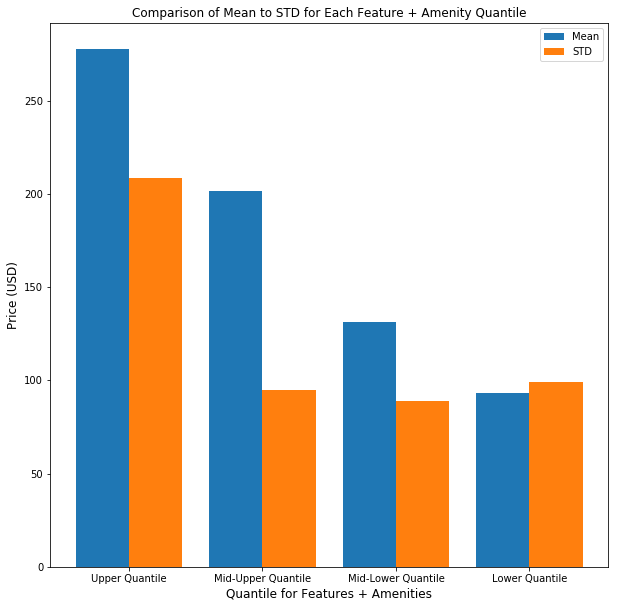

In [25]:
# Plot Barchart for Comparison

plt.figure(figsize=(10,10))
plt.bar(x=np.arange(feat_amen_desc.index.size), height=feat_amen_desc['mean'], width=0.40, label='Mean')
plt.bar(x=np.arange(feat_amen_desc.index.size) + 0.40, height=feat_amen_desc['std'], width=0.40, label='STD')
plt.xticks(np.arange(feat_amen_desc.index.size) + 0.20, feat_amen_desc.index.values)
plt.xlabel('Quantile for Features + Amenities', fontsize='large')
plt.ylabel('Price (USD)', fontsize='large')
plt.legend()
plt.title('Comparison of Mean to STD for Each Feature + Amenity Quantile')
plt.show()

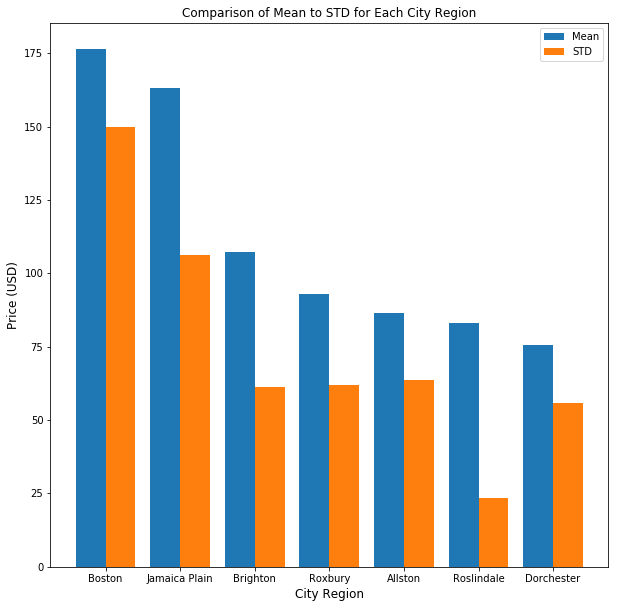

In [26]:
# Plot Barchart for Comparison

plt.figure(figsize=(10,10))
plt.bar(x=np.arange(city_desc.index.size), height=city_desc['mean'], width=0.40, label='Mean')
plt.bar(x=np.arange(city_desc.index.size) + 0.40, height=city_desc['std'], width=0.40, label='STD')
plt.xticks(np.arange(city_desc.index.size) + 0.20, city_desc.index.values)
plt.xlabel('City Region', fontsize='large')
plt.ylabel('Price (USD)', fontsize='large')
plt.legend()
plt.title('Comparison of Mean to STD for Each City Region')
plt.show()

We now create a function to compute the deviation size...

In [27]:
# Define function to compute deviation size
def avg_std(df):
    '''
    INPUT:
        - df: DataFrame to compute mean of statistics
    
    OUTPUT:
        - avg_std: Average of std-to-mean ratios for each row of the DataFrame.
        
    Computes the ratio of std to mean for each row of the DataFrame. 
    Then returns the mean of these ratios.
    '''
    return (df['std'] / df['mean']).mean()

... and compute the sizes:

In [28]:
# Compute deviation sizes
print('Features and Amenities:', avg_std(feat_amen_desc))
print('City:', avg_std(city_desc))

Features and Amenities: 0.7409849238195625
City: 0.6432203759286912


The results show that the deviation size for Features and Amenities is 16% larger than the deviation size for City. 

This means that, although by a slight margin, prices in the dataset are more concentrated around the location of the listing rather than the characteristics like its amenities, etc. 

### Question 2:

##### How correlated are comments/reviews of a listing with the price of a listing and the scores obtained by that listing?  

For this question, we will need to import data from two files containing positive and negative words ('dictionaries'). These will allow us to compare the words in each of the listing reviews to the dictionaries and compute a simple figure of how positive or negative the reviews are.

This figure can then be correlated to the review_score_rating of the listing, to answer our question.

In [29]:
# Create lists of positive and negative words to compare to
neg_dict = np.asarray(pd.read_csv('../Data/negative-words.txt', skiprows=37, sep='\t', header=None, encoding='ISO-8859-1')).reshape(len(pd.read_csv('../Data/negative-words.txt', skiprows=37, sep='\t', header=None, encoding='ISO-8859-1')))
pos_dict = np.asarray(pd.read_csv('../Data/positive-words.txt', skiprows=36, sep='\t', header=None)).reshape(len(pd.read_csv('../Data/positive-words.txt', skiprows=36, sep='\t', header=None)))

With the lists in place, we can proceed to define the function that will gauge the sentiment of each review:

In [30]:
# Necessary import
import string

# Create punctuation list
punctuation = []
for i in range(len(string.punctuation)):
    punctuation.append(string.punctuation[i])
    
# Define function to gauge sentiment
def sentiment_gauger(review):
    '''
    INPUT: 
        - review: String of words relating to a review of a listing.
        
    OUTPUT:
        - weighted sentiment: Calculated average sentiment of the review passed on. 
        
    Removes the puncutation from the review and transforms the string to lowercase.
    Splits the review into a list of words, and then aggregates the positive (+1) and
    negative (-1) words in the review to gauge a sentiment. 
    Returns the sentiment divided by the number of words in the review.
    '''
    
    # Initialize counter
    sentiment = 0
    
    # To lowercase
    review = review.lower()
    
    # Remove puncutation
    for p in punctuation:
        review = review.replace(p, '')
        
    # Split review into list of words
    words = review.split(' ')
    
    # Compute sentiment 
    for word in words:
        if word in pos_dict:
            sentiment += 1
        elif word in neg_dict:
            sentiment += -1
            
    return sentiment / len(words)  

We now proceed to join the 'Boston listing' and 'Boston review' datasets on the 'listing id' column (by changing the name of the 'id' column in the latter dataset).

Because we want to compare the listing reviews (in bos_rev) to their ratings (in bos_list), we are only interested in the inner intersection of both, since we need that each listing to be considered has both a review and a rating. 

In [31]:
# Join listing and review datasets on listing id

# Make column name equal
bos_rev['id'] = bos_rev['listing_id']
bos_rev.drop(['listing_id'], axis=1, inplace=True)

# Join datasets
bos_comb = bos_list.join(bos_rev, on='id', rsuffix='_right', how='inner')

Because we determined that the join would be 'inner', it is good to check how many rows were dropped:

In [32]:
# Examine how many rows were dropped
bos_rev.shape[0] - bos_comb.shape[0]

68207

Impressively, a large amount of rows were dropped. This may suggest that the AirBnB data we are working with is either incomplete or not appropriately related in the database. Be that as it may, we can proceed to answer our question with the data we have. 

The next step is applying the sentiment_gauger function to the reviews of each listing, to obtain a computed sentiment for each:

In [33]:
# Apply sentiment_gauger function
bos_comb['review_sentiment'] = bos_comb['comments'].apply(sentiment_gauger)

# Inspect
bos_comb['review_sentiment'].head()

2      0.028571
166    0.066667
232    0.082353
391    0.046296
400    0.038462
Name: review_sentiment, dtype: float64

With this computation in place, we can gauge the two correlations needed for to answer our question. To better understand the results, we can plot heatmaps of the correlations:

In [34]:
# Define function to plot heatmap for each correlation data

def heatmap(data, features, title):
    '''
        INPUT:
            - data: DataFrame with correlation statistics
            - features: Array of strings with names of features being correlated

        OUTPUT:
            - Heatmap of the correlation statistics between the variables
    '''
    
    # Create heatmap
    fig, ax = plt.subplots()
    im = ax.imshow(bos_comb[features].corr())

    # Set title
    ax.set_title(title)
    
    # Set X-axis ticks and labels
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(features)
    
    # Set Y-axis ticks and labels
    ax.set_yticks(np.arange(2))
    ax.set_yticklabels(features)

    # Set colorbar to gauge correlation
    cbar = ax.figure.colorbar(im, ax=ax)
    cbarlabel = cbar.ax.set_ylabel('Correlation')

    # Include values in each square for reference
    for col in np.arange(len(features)):
        for row in np.arange(len(features)):
            ax.text(col, row, '{:.3f}'.format(bos_comb[features].corr().iloc[col, row]),
                       ha='center', va='center', color='w', fontweight='bold')
    # Show heatmap
    plt.show()

In [35]:
# Examine sentiment correlation with price
bos_comb[['review_sentiment', 'price']].corr()

,review_sentiment,price
review_sentiment,1.000000,-0.146845
price,-0.146845,1.000000


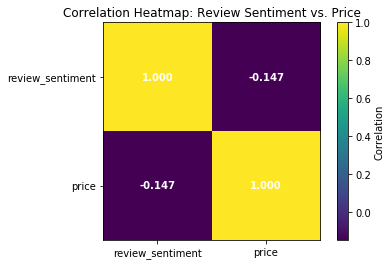

In [36]:
# Plot heatmap for review sentiment vs. price
heatmap(bos_comb[['review_sentiment', 'price']].corr(), 
        ['review_sentiment', 'price'],
        'Correlation Heatmap: Review Sentiment vs. Price')

In [37]:
# Examine sentiment correlation with review rating
bos_comb[['review_sentiment', 'review_scores_rating']].corr()

,review_sentiment,review_scores_rating
review_sentiment,1.000000,-0.111337
review_scores_rating,-0.111337,1.000000


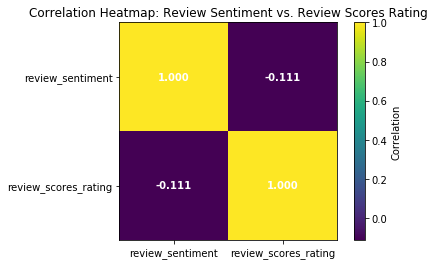

In [38]:
# Plot heatmap for review sentiment vs. review scores rating
heatmap(bos_comb[['review_sentiment', 'review_scores_rating']].corr(), 
        ['review_sentiment', 'review_scores_rating'],
        'Correlation Heatmap: Review Sentiment vs. Review Scores Rating')

The answers obtained suggest that the price of each listing is not correlated well with the sentiment of the listing's reviews. 

Furthermore, the sentiment of the review does not appear to be well correlated with the rating of the listing. 

These answers suggest that the method used to compute the sentiment in the reviews is not necessarily the best. A better approach could be to collect an extensively larger dataset relating listing comments with the ratings, and train an MLP to numerically gauge the sentiment of the comment. 

In addition, these findings suggest that guests usually do not fill their comments with sufficient information on why they rated the listings as they did. This highlights the importance of positive comments for AirBnB hosts: since guests usually give so little information on their comments, a large portion of the effect these comments have on potential guests looking at the listing online depends on the potential guest's subjective interpretation of the comments. Due to the unpredictable nature of human subjectivity and the tendency humans have of adapting content to what they believe in their minds through leaps of inference, it is best for AirBnB hosts to avoid the overwhelming effect a negative comment may have on how they are perceived. 

### Question 3: 

##### Can we predict the price of a listing using some of the variables contained in the dataset?

##### 3.1 Feature Selection

For this question, we will be using some of the variables contained in the dataset and some of the variables we have previously computed to attempt to predict the price of a listing. 

To do so, we can begin by examining all of the columns to determine which ones are useful to us.  

In [39]:
# Inspect column values to determine useful features
bos_list.columns.values

array(['id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'neighbourhood', 'city',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'price', 'guests_included',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'num_amenities',
       'room_type_value', 'bed_type_value', 'feat_amen_total',
       'feat_amen_group'], dtype=object)

From the list above, we can determine which of the variables are useful to us and which are not. For instance, we know that 'state', 'zip code', and 'market' do not provide any variability in the data, and so are not useful. Others, like 'security_deposit' and 'cancellation' are simply not relevant. 'review_sentiment' could be useful, but since it was only possible to calculate it for a tiny subset of the data, it should not be included. 

We can therefore summarize the columns (numeric and categorical) to be used below:

In [40]:
# Separate columns into numeric and categorical features
numeric = ['host_since', 'host_total_listings_count', 'accommodates', 'bathrooms', 'beds', 'guests_included', 
           'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location', 'review_scores_value', 'num_amenities',
           'room_type_value', 'bed_type_value', 'feat_amen_total']

categorical = ['host_is_superhost', 'neighbourhood', 'city']

Before proceeding, we can modify 'host_since' into a more useful format. Since it currently has the date since the host became a host, we can alter this to signify how many years the host has been a host for. This is logical, since a more experienced host is expected to be better.

In [41]:
# Modify 'host_since' column for computation
bos_list['host_since'] = bos_list['host_since'].apply(lambda date: 2016 - int(date[:4]))

We can now extract the columns we will be working with, simply:

In [42]:
# Drop rows with missing values
bos_list_clean = bos_list.dropna(how='any', subset=np.concatenate([numeric, categorical]), axis=0)[np.concatenate([numeric, categorical, ['price']])]

# Inspect
bos_list_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310 entries, 1 to 3574
Data columns (total 21 columns):
host_since                     2310 non-null int64
host_total_listings_count      2310 non-null int64
accommodates                   2310 non-null int64
bathrooms                      2310 non-null float64
beds                           2310 non-null float64
guests_included                2310 non-null int64
review_scores_rating           2310 non-null float64
review_scores_accuracy         2310 non-null float64
review_scores_cleanliness      2310 non-null float64
review_scores_checkin          2310 non-null float64
review_scores_communication    2310 non-null float64
review_scores_location         2310 non-null float64
review_scores_value            2310 non-null float64
num_amenities                  2310 non-null int64
room_type_value                2310 non-null int64
bed_type_value                 2310 non-null int64
feat_amen_total                2310 non-null float64
host_i

Now, we can separate the predictor and target variables:

In [43]:
# Separate data into predictor and target variables
predictors = bos_list_clean.drop(['price'], axis=1)
target = bos_list_clean['price']

# Inspect
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310 entries, 1 to 3574
Data columns (total 20 columns):
host_since                     2310 non-null int64
host_total_listings_count      2310 non-null int64
accommodates                   2310 non-null int64
bathrooms                      2310 non-null float64
beds                           2310 non-null float64
guests_included                2310 non-null int64
review_scores_rating           2310 non-null float64
review_scores_accuracy         2310 non-null float64
review_scores_cleanliness      2310 non-null float64
review_scores_checkin          2310 non-null float64
review_scores_communication    2310 non-null float64
review_scores_location         2310 non-null float64
review_scores_value            2310 non-null float64
num_amenities                  2310 non-null int64
room_type_value                2310 non-null int64
bed_type_value                 2310 non-null int64
feat_amen_total                2310 non-null float64
host_i

##### 3.2 Feature Preprocessing

To facilitate computation, we can convert the categorical variables to the dtype 'category'. This makes it easier to later compute the One-Hot Encoding. 

In [44]:
# Convert categorical columns to 'category' data type
predictors[categorical] = predictors[categorical].apply(lambda col: col.astype('category'))

# Inspect
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310 entries, 1 to 3574
Data columns (total 20 columns):
host_since                     2310 non-null int64
host_total_listings_count      2310 non-null int64
accommodates                   2310 non-null int64
bathrooms                      2310 non-null float64
beds                           2310 non-null float64
guests_included                2310 non-null int64
review_scores_rating           2310 non-null float64
review_scores_accuracy         2310 non-null float64
review_scores_cleanliness      2310 non-null float64
review_scores_checkin          2310 non-null float64
review_scores_communication    2310 non-null float64
review_scores_location         2310 non-null float64
review_scores_value            2310 non-null float64
num_amenities                  2310 non-null int64
room_type_value                2310 non-null int64
bed_type_value                 2310 non-null int64
feat_amen_total                2310 non-null float64
host_i

One-hot encode categoricals:

In [45]:
# One-hot encode categoricals
predictors = pd.get_dummies(predictors)

Normalize numeric variables for optimal model performance:

In [46]:
# Normalize numeric variables for better model performance

# Import scaler
from sklearn.preprocessing import MinMaxScaler

# Normalize values
scaler = MinMaxScaler()
predictors[numeric] = scaler.fit_transform(predictors[numeric])

##### 3.3 Training and Testing Split

Split data into training and testing:

In [47]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, shuffle=True, random_state=42)

##### 3.4 Training and Evaluating Models

###### Model 1: SVR

For the first model, we will be using a Support Vector Machine Regressor, and fine-tuning it using Grid Search Cross-Validation:

In [48]:
# Necessary imports
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Create regressor object
regressor_1 = SVR()

# Define parameters to be optimized
kernel = ['linear', 'poly', 'rbf']
gamma = [0.001, 0.01, 0.1, 1]
c = [0.001, 0.01, 0.1, 1, 10]
epsilon = [0.01, 0.1, 1.0]
params = {'gamma': gamma, 'C': c, 'kernel': kernel, 'epsilon': epsilon}

# Create and train Grid Search Cross-Validation object
grid_1 = GridSearchCV(regressor_1, param_grid=params, scoring='neg_mean_squared_error', verbose=4)
grid_result_1 = grid_1.fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=linear ...............
[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=linear, score=-14618.311997806608, total=   0.1s
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=linear ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=linear, score=-13227.43917418862, total=   0.1s
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=linear ...............
[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=linear, score=-14578.166730079796, total=   0.1s
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=poly .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=poly, score=-14635.761717849708, total=   0.1s
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=poly .................
[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=poly, score=-13244.588533635962, total=   0.1s
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=poly .................
[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=poly, score=-14595.42564315448, total=   0.1s
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=rbf ..................
[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=rbf, score=-14635.734831136118, total=   0.2s
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=rbf ..................
[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=rbf, score=-13244.550329874432, total=   0.2s
[CV] C=0.001, epsilon=0.01, gamma=0.001, kernel=rbf ..................
[CV]  C=0.001, epsilon=0.01, gamma=0.001, kernel=rbf, score=-14595.38596855331, total=   0.2s
[CV] C=0.001, epsilon=0.01, gamma=0.01, kernel=linear ................
[CV

[CV]  C=0.001, epsilon=0.1, gamma=0.01, kernel=rbf, score=-14598.573330553503, total=   0.2s
[CV] C=0.001, epsilon=0.1, gamma=0.1, kernel=linear ..................
[CV]  C=0.001, epsilon=0.1, gamma=0.1, kernel=linear, score=-14614.750830675663, total=   0.1s
[CV] C=0.001, epsilon=0.1, gamma=0.1, kernel=linear ..................
[CV]  C=0.001, epsilon=0.1, gamma=0.1, kernel=linear, score=-13228.175992884646, total=   0.1s
[CV] C=0.001, epsilon=0.1, gamma=0.1, kernel=linear ..................
[CV]  C=0.001, epsilon=0.1, gamma=0.1, kernel=linear, score=-14579.071411909088, total=   0.1s
[CV] C=0.001, epsilon=0.1, gamma=0.1, kernel=poly ....................
[CV]  C=0.001, epsilon=0.1, gamma=0.1, kernel=poly, score=-14624.268870396521, total=   0.1s
[CV] C=0.001, epsilon=0.1, gamma=0.1, kernel=poly ....................
[CV]  C=0.001, epsilon=0.1, gamma=0.1, kernel=poly, score=-13239.402663159388, total=   0.1s
[CV] C=0.001, epsilon=0.1, gamma=0.1, kernel=poly ....................
[CV]  C=0.

[CV]  C=0.001, epsilon=1.0, gamma=1, kernel=poly, score=-10633.179502155761, total=   0.1s
[CV] C=0.001, epsilon=1.0, gamma=1, kernel=rbf .......................
[CV]  C=0.001, epsilon=1.0, gamma=1, kernel=rbf, score=-14570.468068150936, total=   0.2s
[CV] C=0.001, epsilon=1.0, gamma=1, kernel=rbf .......................
[CV]  C=0.001, epsilon=1.0, gamma=1, kernel=rbf, score=-13272.051793285435, total=   0.2s
[CV] C=0.001, epsilon=1.0, gamma=1, kernel=rbf .......................
[CV]  C=0.001, epsilon=1.0, gamma=1, kernel=rbf, score=-14631.44816186126, total=   0.2s
[CV] C=0.01, epsilon=0.01, gamma=0.001, kernel=linear ................
[CV]  C=0.01, epsilon=0.01, gamma=0.001, kernel=linear, score=-14451.231235201029, total=   0.1s
[CV] C=0.01, epsilon=0.01, gamma=0.001, kernel=linear ................
[CV]  C=0.01, epsilon=0.01, gamma=0.001, kernel=linear, score=-13079.671296203387, total=   0.1s
[CV] C=0.01, epsilon=0.01, gamma=0.001, kernel=linear ................
[CV]  C=0.01, epsilo

[CV]  C=0.01, epsilon=0.1, gamma=0.01, kernel=linear, score=-13078.186178016527, total=   0.1s
[CV] C=0.01, epsilon=0.1, gamma=0.01, kernel=linear ..................
[CV]  C=0.01, epsilon=0.1, gamma=0.01, kernel=linear, score=-14427.689464529272, total=   0.1s
[CV] C=0.01, epsilon=0.1, gamma=0.01, kernel=poly ....................
[CV]  C=0.01, epsilon=0.1, gamma=0.01, kernel=poly, score=-14629.742969216331, total=   0.1s
[CV] C=0.01, epsilon=0.1, gamma=0.01, kernel=poly ....................
[CV]  C=0.01, epsilon=0.1, gamma=0.01, kernel=poly, score=-13247.243756098005, total=   0.1s
[CV] C=0.01, epsilon=0.1, gamma=0.01, kernel=poly ....................
[CV]  C=0.01, epsilon=0.1, gamma=0.01, kernel=poly, score=-14598.870729905477, total=   0.1s
[CV] C=0.01, epsilon=0.1, gamma=0.01, kernel=rbf .....................
[CV]  C=0.01, epsilon=0.1, gamma=0.01, kernel=rbf, score=-14627.18964331924, total=   0.2s
[CV] C=0.01, epsilon=0.1, gamma=0.01, kernel=rbf .....................
[CV]  C=0.01, 

[CV]  C=0.01, epsilon=1.0, gamma=0.1, kernel=rbf, score=-13243.104081129226, total=   0.2s
[CV] C=0.01, epsilon=1.0, gamma=0.1, kernel=rbf ......................
[CV]  C=0.01, epsilon=1.0, gamma=0.1, kernel=rbf, score=-14601.032009168122, total=   0.1s
[CV] C=0.01, epsilon=1.0, gamma=1, kernel=linear .....................
[CV]  C=0.01, epsilon=1.0, gamma=1, kernel=linear, score=-14427.216169257115, total=   0.1s
[CV] C=0.01, epsilon=1.0, gamma=1, kernel=linear .....................
[CV]  C=0.01, epsilon=1.0, gamma=1, kernel=linear, score=-13078.011364098364, total=   0.1s
[CV] C=0.01, epsilon=1.0, gamma=1, kernel=linear .....................
[CV]  C=0.01, epsilon=1.0, gamma=1, kernel=linear, score=-14418.008176289311, total=   0.1s
[CV] C=0.01, epsilon=1.0, gamma=1, kernel=poly .......................
[CV]  C=0.01, epsilon=1.0, gamma=1, kernel=poly, score=-7494.521389980897, total=   0.1s
[CV] C=0.01, epsilon=1.0, gamma=1, kernel=poly .......................
[CV]  C=0.01, epsilon=1.0, 

[CV]  C=0.1, epsilon=0.1, gamma=0.001, kernel=poly, score=-14598.957821581576, total=   0.1s
[CV] C=0.1, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=0.1, epsilon=0.1, gamma=0.001, kernel=rbf, score=-14627.10619670669, total=   0.2s
[CV] C=0.1, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=0.1, epsilon=0.1, gamma=0.001, kernel=rbf, score=-13243.503363376129, total=   0.2s
[CV] C=0.1, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=0.1, epsilon=0.1, gamma=0.001, kernel=rbf, score=-14594.991304592217, total=   0.2s
[CV] C=0.1, epsilon=0.1, gamma=0.01, kernel=linear ...................
[CV]  C=0.1, epsilon=0.1, gamma=0.01, kernel=linear, score=-13209.844481302896, total=   0.1s
[CV] C=0.1, epsilon=0.1, gamma=0.01, kernel=linear ...................
[CV]  C=0.1, epsilon=0.1, gamma=0.01, kernel=linear, score=-11754.802757446001, total=   0.1s
[CV] C=0.1, epsilon=0.1, gamma=0.01, kernel=linear ...................
[CV]  C=0.1, epsil

[CV]  C=0.1, epsilon=1.0, gamma=0.1, kernel=linear, score=-13058.923706186899, total=   0.2s
[CV] C=0.1, epsilon=1.0, gamma=0.1, kernel=poly ......................
[CV]  C=0.1, epsilon=1.0, gamma=0.1, kernel=poly, score=-13993.9559945214, total=   0.1s
[CV] C=0.1, epsilon=1.0, gamma=0.1, kernel=poly ......................
[CV]  C=0.1, epsilon=1.0, gamma=0.1, kernel=poly, score=-12594.517391160749, total=   0.1s
[CV] C=0.1, epsilon=1.0, gamma=0.1, kernel=poly ......................
[CV]  C=0.1, epsilon=1.0, gamma=0.1, kernel=poly, score=-13943.58852426475, total=   0.1s
[CV] C=0.1, epsilon=1.0, gamma=0.1, kernel=rbf .......................
[CV]  C=0.1, epsilon=1.0, gamma=0.1, kernel=rbf, score=-14354.792667037245, total=   0.2s
[CV] C=0.1, epsilon=1.0, gamma=0.1, kernel=rbf .......................
[CV]  C=0.1, epsilon=1.0, gamma=0.1, kernel=rbf, score=-13000.229024735134, total=   0.2s
[CV] C=0.1, epsilon=1.0, gamma=0.1, kernel=rbf .......................
[CV]  C=0.1, epsilon=1.0, gamma

[CV]  C=1, epsilon=0.01, gamma=1, kernel=rbf, score=-12609.394908003884, total=   0.2s
[CV] C=1, epsilon=0.1, gamma=0.001, kernel=linear ....................
[CV]  C=1, epsilon=0.1, gamma=0.001, kernel=linear, score=-9463.583296593766, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001, kernel=linear ....................
[CV]  C=1, epsilon=0.1, gamma=0.001, kernel=linear, score=-8357.414228237007, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001, kernel=linear ....................
[CV]  C=1, epsilon=0.1, gamma=0.001, kernel=linear, score=-9283.96346107033, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001, kernel=poly ......................
[CV]  C=1, epsilon=0.1, gamma=0.001, kernel=poly, score=-14629.7927773973, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001, kernel=poly ......................
[CV]  C=1, epsilon=0.1, gamma=0.001, kernel=poly, score=-13247.315063896365, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001, kernel=poly ......................
[CV]  C=1, epsilon=0.1, gamma=0.

[CV]  C=1, epsilon=1.0, gamma=0.01, kernel=rbf, score=-14270.004087564106, total=   0.2s
[CV] C=1, epsilon=1.0, gamma=0.01, kernel=rbf ........................
[CV]  C=1, epsilon=1.0, gamma=0.01, kernel=rbf, score=-12918.064656522225, total=   0.2s
[CV] C=1, epsilon=1.0, gamma=0.01, kernel=rbf ........................
[CV]  C=1, epsilon=1.0, gamma=0.01, kernel=rbf, score=-14261.690253194318, total=   0.2s
[CV] C=1, epsilon=1.0, gamma=0.1, kernel=linear ......................
[CV]  C=1, epsilon=1.0, gamma=0.1, kernel=linear, score=-9427.613481005945, total=   0.1s
[CV] C=1, epsilon=1.0, gamma=0.1, kernel=linear ......................
[CV]  C=1, epsilon=1.0, gamma=0.1, kernel=linear, score=-8353.87056521707, total=   0.1s
[CV] C=1, epsilon=1.0, gamma=0.1, kernel=linear ......................
[CV]  C=1, epsilon=1.0, gamma=0.1, kernel=linear, score=-9270.256587815513, total=   0.1s
[CV] C=1, epsilon=1.0, gamma=0.1, kernel=poly ........................
[CV]  C=1, epsilon=1.0, gamma=0.1, ker

[CV]  C=10, epsilon=0.01, gamma=1, kernel=poly, score=-5732.740757916919, total=   1.8s
[CV] C=10, epsilon=0.01, gamma=1, kernel=poly ........................
[CV]  C=10, epsilon=0.01, gamma=1, kernel=poly, score=-4476.467195707444, total=   2.0s
[CV] C=10, epsilon=0.01, gamma=1, kernel=poly ........................
[CV]  C=10, epsilon=0.01, gamma=1, kernel=poly, score=-5312.623145123505, total=   1.7s
[CV] C=10, epsilon=0.01, gamma=1, kernel=rbf .........................
[CV]  C=10, epsilon=0.01, gamma=1, kernel=rbf, score=-9028.781536995895, total=   0.2s
[CV] C=10, epsilon=0.01, gamma=1, kernel=rbf .........................
[CV]  C=10, epsilon=0.01, gamma=1, kernel=rbf, score=-8231.192453750908, total=   0.2s
[CV] C=10, epsilon=0.01, gamma=1, kernel=rbf .........................
[CV]  C=10, epsilon=0.01, gamma=1, kernel=rbf, score=-8962.99383571409, total=   0.2s
[CV] C=10, epsilon=0.1, gamma=0.001, kernel=linear ...................
[CV]  C=10, epsilon=0.1, gamma=0.001, kernel=linea

[CV]  C=10, epsilon=1.0, gamma=0.01, kernel=linear, score=-6567.7818841967055, total=   0.1s
[CV] C=10, epsilon=1.0, gamma=0.01, kernel=linear ....................
[CV]  C=10, epsilon=1.0, gamma=0.01, kernel=linear, score=-7199.770961110169, total=   0.1s
[CV] C=10, epsilon=1.0, gamma=0.01, kernel=poly ......................
[CV]  C=10, epsilon=1.0, gamma=0.01, kernel=poly, score=-14522.864695055585, total=   0.1s
[CV] C=10, epsilon=1.0, gamma=0.01, kernel=poly ......................
[CV]  C=10, epsilon=1.0, gamma=0.01, kernel=poly, score=-13188.45070914707, total=   0.1s
[CV] C=10, epsilon=1.0, gamma=0.01, kernel=poly ......................
[CV]  C=10, epsilon=1.0, gamma=0.01, kernel=poly, score=-14535.74290332247, total=   0.1s
[CV] C=10, epsilon=1.0, gamma=0.01, kernel=rbf .......................
[CV]  C=10, epsilon=1.0, gamma=0.01, kernel=rbf, score=-12134.57276022897, total=   0.2s
[CV] C=10, epsilon=1.0, gamma=0.01, kernel=rbf .......................
[CV]  C=10, epsilon=1.0, gamm

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.1min finished


In [49]:
# Compute score with best regressor parameters
y_pred = grid_result_1.best_estimator_.predict(X_test)
print('MSE Score:', mean_squared_error(y_test, y_pred))
print('MSE Root (Mean Error):', np.sqrt(mean_squared_error(y_test, y_pred)))

MSE Score: 5053.452993242856
MSE Root (Mean Error): 71.08764304183151


##### Model 2: SGDRegressor

For the second model, we will be using a Stochastic Gradient Descent Regressor, and fine-tuning it using Grid Search Cross-Validation:

In [50]:
# Necessary imports
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

# Create regressor object
regressor_2 = SGDRegressor()

# Define parameters to be optimized
loss = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
penalty = ['l2', 'l1', 'elasticnet']
learning_rate = ['constant', 'optimal', 'invscaling']
params = {'loss': loss, 'penalty': penalty, 'learning_rate': learning_rate}

# Create and train Grid Search Cross-Validation object
grid_2 = GridSearchCV(regressor_2, param_grid=params, scoring='neg_mean_squared_error', verbose=4)
grid_result_2 = grid_2.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=constant, loss=squared_loss, penalty=l2 ...........
[CV]  learning_rate=constant, loss=squared_loss, penalty=l2, score=-7038.057545743508, total=   0.0s
[CV] learning_rate=constant, loss=squared_loss, penalty=l2 ...........
[CV]  learning_rate=constant, loss=squared_loss, penalty=l2, score=-5985.791926089734, total=   0.0s
[CV] learning_rate=constant, loss=squared_loss, penalty=l2 ...........
[CV]  learning_rate=constant, loss=squared_loss, penalty=l2, score=-6629.862334462789, total=   0.0s
[CV] learning_rate=constant, loss=squared_loss, penalty=l1 ...........
[CV]  learning_rate=constant, loss=squared_loss, penalty=l1, score=-6725.706497630571, total=   0.0s
[CV] learning_rate=constant, loss=squared_loss, penalty=l1 ...........
[CV]  learning_rate=constant, loss=squared_loss, penalty=l1, score=-6068.314386963501, total=   0.0s
[CV] learning_rate=constant, loss=squared_loss, penalty=l1 ...........
[CV]  l

/Users/MHurtado/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/MHurtado/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1

[CV]  learning_rate=optimal, loss=squared_loss, penalty=l2, score=-2.28325918378482e+25, total=   0.0s
[CV] learning_rate=optimal, loss=squared_loss, penalty=l2 ............
[CV]  learning_rate=optimal, loss=squared_loss, penalty=l2, score=-2.6638222909080675e+25, total=   0.0s
[CV] learning_rate=optimal, loss=squared_loss, penalty=l2 ............
[CV]  learning_rate=optimal, loss=squared_loss, penalty=l2, score=-7.339837901927106e+25, total=   0.0s
[CV] learning_rate=optimal, loss=squared_loss, penalty=l1 ............
[CV]  learning_rate=optimal, loss=squared_loss, penalty=l1, score=-3.1879184747753702e+25, total=   0.0s
[CV] learning_rate=optimal, loss=squared_loss, penalty=l1 ............
[CV]  learning_rate=optimal, loss=squared_loss, penalty=l1, score=-3.2406053851606095e+26, total=   0.0s
[CV] learning_rate=optimal, loss=squared_loss, penalty=l1 ............
[CV]  learning_rate=optimal, loss=squared_loss, penalty=l1, score=-2.0221308700701958e+25, total=   0.0s
[CV] learning_rate

/Users/MHurtado/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/MHurtado/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/MHurt

[CV]  learning_rate=invscaling, loss=squared_loss, penalty=l2, score=-7447.134800606008, total=   0.0s
[CV] learning_rate=invscaling, loss=squared_loss, penalty=l2 .........
[CV]  learning_rate=invscaling, loss=squared_loss, penalty=l2, score=-8546.610083319005, total=   0.0s
[CV] learning_rate=invscaling, loss=squared_loss, penalty=l1 .........
[CV]  learning_rate=invscaling, loss=squared_loss, penalty=l1, score=-7832.884961085337, total=   0.0s
[CV] learning_rate=invscaling, loss=squared_loss, penalty=l1 .........
[CV]  learning_rate=invscaling, loss=squared_loss, penalty=l1, score=-7402.862626230525, total=   0.0s
[CV] learning_rate=invscaling, loss=squared_loss, penalty=l1 .........
[CV]  learning_rate=invscaling, loss=squared_loss, penalty=l1, score=-8442.834937033424, total=   0.0s
[CV] learning_rate=invscaling, loss=squared_loss, penalty=elasticnet .
[CV]  learning_rate=invscaling, loss=squared_loss, penalty=elasticnet, score=-7864.448062392023, total=   0.0s
[CV] learning_rate=

/Users/MHurtado/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/MHurtado/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/MHurt

In [51]:
# Compute score with best regressor parameters
y_pred = grid_result_2.best_estimator_.predict(X_test)
print('MSE Score:', mean_squared_error(y_test, y_pred))
print('MSE Root (Mean Error):', np.sqrt(mean_squared_error(y_test, y_pred)))

MSE Score: 5288.435603687248
MSE Root (Mean Error): 72.72163092015502


##### Model 3: Multi-Layer Perceptron

For the third model, we will be using a Multi-Layer Perceptron with a simple architecture and using a checkpointer to save the best weights throughout the training process, to then evaluate its performance:

In [52]:
# Necessary imports
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

# Create checkpointer to save best weights
checkpointer = ModelCheckpoint('best_weights.hdf5', save_weights_only=True, save_best_only=True, verbose=2)

# Define model architecture
regressor_3 = Sequential()
regressor_3.add(Dense(units=X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
regressor_3.add(Dense(units=53, activation='relu'))
regressor_3.add(Dropout(0.2))
regressor_3.add(Dense(units=27, activation='relu'))
regressor_3.add(Dense(units=27, activation='relu'))
regressor_3.add(Dropout(0.2))
regressor_3.add(Dense(units=13, activation='relu'))
regressor_3.add(Dense(units=1, activation='linear'))

# Compile model
regressor_3.compile(loss='mse', optimizer='rmsprop', metrics=['mean_squared_error'])

# Train model
regressor_3.fit(X_train, y_train, epochs=500, batch_size=40, verbose=2, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

# Load best weights
regressor_3.load_weights('best_weights.hdf5')

/Users/MHurtado/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 1478 samples, validate on 370 samples
Epoch 1/500
 - 0s - loss: 39023.6023 - mean_squared_error: 39023.6023 - val_loss: 30993.0933 - val_mean_squared_error: 30993.0933

Epoch 00001: val_loss improved from inf to 30993.09333, saving model to best_weights.hdf5
Epoch 2/500
 - 0s - loss: 17332.6327 - mean_squared_error: 17332.6327 - val_loss: 13203.3117 - val_mean_squared_error: 13203.3117

Epoch 00002: val_loss improved from 30993.09333 to 13203.31173, saving model to best_weights.hdf5
Epoch 3/500
 - 0s - loss: 11941.4005 - mean_squared_error: 11941.4005 - val_loss: 12696.7553 - val_mean_squared_error: 12696.7553

Epoch 00003: val_loss improved from 13203.31173 to 12696.75525, saving model to best_weights.hdf5
Epoch 4/500
 - 0s - loss: 11439.4254 - mean_squared_error: 11439.4254 - val_loss: 11833.3853 - val_mean_squared_error: 11833.3853

Epoch 00004: val_loss improved from 12696.75525 to 11833.38529, saving model to best_weights.hdf5
Epoch 5/500
 - 0s - loss: 10812.6153 - mean_s


Epoch 00041: val_loss did not improve from 6115.16208
Epoch 42/500
 - 0s - loss: 6153.8509 - mean_squared_error: 6153.8509 - val_loss: 6256.5915 - val_mean_squared_error: 6256.5915

Epoch 00042: val_loss did not improve from 6115.16208
Epoch 43/500
 - 0s - loss: 6101.9279 - mean_squared_error: 6101.9279 - val_loss: 6076.4866 - val_mean_squared_error: 6076.4866

Epoch 00043: val_loss improved from 6115.16208 to 6076.48663, saving model to best_weights.hdf5
Epoch 44/500
 - 0s - loss: 5957.5735 - mean_squared_error: 5957.5735 - val_loss: 5968.7152 - val_mean_squared_error: 5968.7152

Epoch 00044: val_loss improved from 6076.48663 to 5968.71522, saving model to best_weights.hdf5
Epoch 45/500
 - 0s - loss: 5975.8994 - mean_squared_error: 5975.8994 - val_loss: 5941.1206 - val_mean_squared_error: 5941.1206

Epoch 00045: val_loss improved from 5968.71522 to 5941.12063, saving model to best_weights.hdf5
Epoch 46/500
 - 0s - loss: 5999.0614 - mean_squared_error: 5999.0614 - val_loss: 6181.0352 


Epoch 00084: val_loss did not improve from 5586.63212
Epoch 85/500
 - 0s - loss: 5090.7265 - mean_squared_error: 5090.7265 - val_loss: 5930.8630 - val_mean_squared_error: 5930.8630

Epoch 00085: val_loss did not improve from 5586.63212
Epoch 86/500
 - 0s - loss: 5093.1095 - mean_squared_error: 5093.1095 - val_loss: 5523.4771 - val_mean_squared_error: 5523.4771

Epoch 00086: val_loss improved from 5586.63212 to 5523.47709, saving model to best_weights.hdf5
Epoch 87/500
 - 0s - loss: 5253.6561 - mean_squared_error: 5253.6561 - val_loss: 5821.3327 - val_mean_squared_error: 5821.3327

Epoch 00087: val_loss did not improve from 5523.47709
Epoch 88/500
 - 0s - loss: 5299.9839 - mean_squared_error: 5299.9839 - val_loss: 5624.7310 - val_mean_squared_error: 5624.7310

Epoch 00088: val_loss did not improve from 5523.47709
Epoch 89/500
 - 0s - loss: 5132.8579 - mean_squared_error: 5132.8579 - val_loss: 5479.9815 - val_mean_squared_error: 5479.9815

Epoch 00089: val_loss improved from 5523.47709 

Epoch 128/500
 - 0s - loss: 4576.4988 - mean_squared_error: 4576.4988 - val_loss: 5631.7313 - val_mean_squared_error: 5631.7313

Epoch 00128: val_loss did not improve from 5317.14550
Epoch 129/500
 - 0s - loss: 4601.4934 - mean_squared_error: 4601.4934 - val_loss: 5356.6502 - val_mean_squared_error: 5356.6502

Epoch 00129: val_loss did not improve from 5317.14550
Epoch 130/500
 - 0s - loss: 4145.5645 - mean_squared_error: 4145.5645 - val_loss: 5548.0368 - val_mean_squared_error: 5548.0368

Epoch 00130: val_loss did not improve from 5317.14550
Epoch 131/500
 - 0s - loss: 4147.5113 - mean_squared_error: 4147.5113 - val_loss: 5815.1367 - val_mean_squared_error: 5815.1367

Epoch 00131: val_loss did not improve from 5317.14550
Epoch 132/500
 - 0s - loss: 4565.3115 - mean_squared_error: 4565.3115 - val_loss: 5659.5556 - val_mean_squared_error: 5659.5556

Epoch 00132: val_loss did not improve from 5317.14550
Epoch 133/500
 - 0s - loss: 4324.4345 - mean_squared_error: 4324.4345 - val_loss: 540

 - 0s - loss: 3799.4377 - mean_squared_error: 3799.4377 - val_loss: 5522.8591 - val_mean_squared_error: 5522.8591

Epoch 00173: val_loss did not improve from 5317.14550
Epoch 174/500
 - 0s - loss: 3522.5977 - mean_squared_error: 3522.5977 - val_loss: 5718.2319 - val_mean_squared_error: 5718.2319

Epoch 00174: val_loss did not improve from 5317.14550
Epoch 175/500
 - 0s - loss: 3569.9136 - mean_squared_error: 3569.9136 - val_loss: 5273.4312 - val_mean_squared_error: 5273.4312

Epoch 00175: val_loss improved from 5317.14550 to 5273.43121, saving model to best_weights.hdf5
Epoch 176/500
 - 0s - loss: 3618.0409 - mean_squared_error: 3618.0409 - val_loss: 5586.1986 - val_mean_squared_error: 5586.1986

Epoch 00176: val_loss did not improve from 5273.43121
Epoch 177/500
 - 0s - loss: 3809.2846 - mean_squared_error: 3809.2846 - val_loss: 6277.2570 - val_mean_squared_error: 6277.2570

Epoch 00177: val_loss did not improve from 5273.43121
Epoch 178/500
 - 0s - loss: 3667.7357 - mean_squared_erro


Epoch 00217: val_loss did not improve from 5273.43121
Epoch 218/500
 - 0s - loss: 3422.8207 - mean_squared_error: 3422.8207 - val_loss: 6171.8227 - val_mean_squared_error: 6171.8227

Epoch 00218: val_loss did not improve from 5273.43121
Epoch 219/500
 - 0s - loss: 3483.8017 - mean_squared_error: 3483.8017 - val_loss: 5945.4387 - val_mean_squared_error: 5945.4387

Epoch 00219: val_loss did not improve from 5273.43121
Epoch 220/500
 - 0s - loss: 3102.3296 - mean_squared_error: 3102.3296 - val_loss: 5846.9978 - val_mean_squared_error: 5846.9978

Epoch 00220: val_loss did not improve from 5273.43121
Epoch 221/500
 - 0s - loss: 3201.7767 - mean_squared_error: 3201.7767 - val_loss: 7279.3116 - val_mean_squared_error: 7279.3116

Epoch 00221: val_loss did not improve from 5273.43121
Epoch 222/500
 - 0s - loss: 3478.2451 - mean_squared_error: 3478.2451 - val_loss: 6292.5123 - val_mean_squared_error: 6292.5123

Epoch 00222: val_loss did not improve from 5273.43121
Epoch 223/500
 - 0s - loss: 33


Epoch 00262: val_loss did not improve from 5273.43121
Epoch 263/500
 - 0s - loss: 3112.9999 - mean_squared_error: 3112.9999 - val_loss: 6090.9955 - val_mean_squared_error: 6090.9955

Epoch 00263: val_loss did not improve from 5273.43121
Epoch 264/500
 - 0s - loss: 3020.0901 - mean_squared_error: 3020.0901 - val_loss: 6976.8765 - val_mean_squared_error: 6976.8765

Epoch 00264: val_loss did not improve from 5273.43121
Epoch 265/500
 - 0s - loss: 2875.2101 - mean_squared_error: 2875.2101 - val_loss: 6261.3841 - val_mean_squared_error: 6261.3841

Epoch 00265: val_loss did not improve from 5273.43121
Epoch 266/500
 - 0s - loss: 2932.7398 - mean_squared_error: 2932.7398 - val_loss: 6645.3441 - val_mean_squared_error: 6645.3441

Epoch 00266: val_loss did not improve from 5273.43121
Epoch 267/500
 - 0s - loss: 2948.5023 - mean_squared_error: 2948.5023 - val_loss: 6515.0491 - val_mean_squared_error: 6515.0491

Epoch 00267: val_loss did not improve from 5273.43121
Epoch 268/500
 - 0s - loss: 29


Epoch 00307: val_loss did not improve from 5273.43121
Epoch 308/500
 - 0s - loss: 2681.3747 - mean_squared_error: 2681.3747 - val_loss: 6490.9816 - val_mean_squared_error: 6490.9816

Epoch 00308: val_loss did not improve from 5273.43121
Epoch 309/500
 - 0s - loss: 2748.6940 - mean_squared_error: 2748.6940 - val_loss: 6161.4569 - val_mean_squared_error: 6161.4569

Epoch 00309: val_loss did not improve from 5273.43121
Epoch 310/500
 - 0s - loss: 2842.9995 - mean_squared_error: 2842.9995 - val_loss: 6795.9920 - val_mean_squared_error: 6795.9920

Epoch 00310: val_loss did not improve from 5273.43121
Epoch 311/500
 - 0s - loss: 2554.9831 - mean_squared_error: 2554.9831 - val_loss: 6301.4817 - val_mean_squared_error: 6301.4817

Epoch 00311: val_loss did not improve from 5273.43121
Epoch 312/500
 - 0s - loss: 2651.2229 - mean_squared_error: 2651.2229 - val_loss: 6148.1730 - val_mean_squared_error: 6148.1730

Epoch 00312: val_loss did not improve from 5273.43121
Epoch 313/500
 - 0s - loss: 28


Epoch 00352: val_loss did not improve from 5273.43121
Epoch 353/500
 - 0s - loss: 2599.9184 - mean_squared_error: 2599.9184 - val_loss: 8369.4360 - val_mean_squared_error: 8369.4360

Epoch 00353: val_loss did not improve from 5273.43121
Epoch 354/500
 - 0s - loss: 2490.8975 - mean_squared_error: 2490.8975 - val_loss: 6148.3904 - val_mean_squared_error: 6148.3904

Epoch 00354: val_loss did not improve from 5273.43121
Epoch 355/500
 - 0s - loss: 2299.6474 - mean_squared_error: 2299.6474 - val_loss: 5806.8030 - val_mean_squared_error: 5806.8030

Epoch 00355: val_loss did not improve from 5273.43121
Epoch 356/500
 - 0s - loss: 2548.0553 - mean_squared_error: 2548.0553 - val_loss: 6424.0793 - val_mean_squared_error: 6424.0793

Epoch 00356: val_loss did not improve from 5273.43121
Epoch 357/500
 - 0s - loss: 2354.0527 - mean_squared_error: 2354.0527 - val_loss: 6160.0671 - val_mean_squared_error: 6160.0671

Epoch 00357: val_loss did not improve from 5273.43121
Epoch 358/500
 - 0s - loss: 24


Epoch 00397: val_loss did not improve from 5273.43121
Epoch 398/500
 - 0s - loss: 2245.5438 - mean_squared_error: 2245.5438 - val_loss: 6703.9224 - val_mean_squared_error: 6703.9224

Epoch 00398: val_loss did not improve from 5273.43121
Epoch 399/500
 - 0s - loss: 2196.9242 - mean_squared_error: 2196.9242 - val_loss: 6965.4296 - val_mean_squared_error: 6965.4296

Epoch 00399: val_loss did not improve from 5273.43121
Epoch 400/500
 - 0s - loss: 2352.3441 - mean_squared_error: 2352.3441 - val_loss: 7326.1647 - val_mean_squared_error: 7326.1647

Epoch 00400: val_loss did not improve from 5273.43121
Epoch 401/500
 - 0s - loss: 2158.7921 - mean_squared_error: 2158.7921 - val_loss: 6285.9695 - val_mean_squared_error: 6285.9695

Epoch 00401: val_loss did not improve from 5273.43121
Epoch 402/500
 - 0s - loss: 2250.9610 - mean_squared_error: 2250.9610 - val_loss: 6702.4936 - val_mean_squared_error: 6702.4936

Epoch 00402: val_loss did not improve from 5273.43121
Epoch 403/500
 - 0s - loss: 23


Epoch 00442: val_loss did not improve from 5273.43121
Epoch 443/500
 - 0s - loss: 2325.6037 - mean_squared_error: 2325.6037 - val_loss: 6542.1959 - val_mean_squared_error: 6542.1959

Epoch 00443: val_loss did not improve from 5273.43121
Epoch 444/500
 - 0s - loss: 2052.2225 - mean_squared_error: 2052.2225 - val_loss: 7579.3921 - val_mean_squared_error: 7579.3921

Epoch 00444: val_loss did not improve from 5273.43121
Epoch 445/500
 - 0s - loss: 2236.6240 - mean_squared_error: 2236.6240 - val_loss: 7861.6398 - val_mean_squared_error: 7861.6398

Epoch 00445: val_loss did not improve from 5273.43121
Epoch 446/500
 - 0s - loss: 2065.8822 - mean_squared_error: 2065.8822 - val_loss: 6895.8873 - val_mean_squared_error: 6895.8873

Epoch 00446: val_loss did not improve from 5273.43121
Epoch 447/500
 - 0s - loss: 2229.1691 - mean_squared_error: 2229.1691 - val_loss: 9278.9958 - val_mean_squared_error: 9278.9958

Epoch 00447: val_loss did not improve from 5273.43121
Epoch 448/500
 - 0s - loss: 20


Epoch 00487: val_loss did not improve from 5273.43121
Epoch 488/500
 - 0s - loss: 2043.4875 - mean_squared_error: 2043.4875 - val_loss: 6802.3611 - val_mean_squared_error: 6802.3611

Epoch 00488: val_loss did not improve from 5273.43121
Epoch 489/500
 - 0s - loss: 1956.7653 - mean_squared_error: 1956.7653 - val_loss: 7122.3468 - val_mean_squared_error: 7122.3468

Epoch 00489: val_loss did not improve from 5273.43121
Epoch 490/500
 - 0s - loss: 2084.8080 - mean_squared_error: 2084.8080 - val_loss: 7612.4949 - val_mean_squared_error: 7612.4949

Epoch 00490: val_loss did not improve from 5273.43121
Epoch 491/500
 - 0s - loss: 2001.2503 - mean_squared_error: 2001.2503 - val_loss: 7142.4345 - val_mean_squared_error: 7142.4345

Epoch 00491: val_loss did not improve from 5273.43121
Epoch 492/500
 - 0s - loss: 1855.3224 - mean_squared_error: 1855.3224 - val_loss: 7592.9003 - val_mean_squared_error: 7592.9003

Epoch 00492: val_loss did not improve from 5273.43121
Epoch 493/500
 - 0s - loss: 19

In [53]:
# Compute score
y_pred = regressor_3.predict(X_test)
print('MSE Score:', mean_squared_error(y_test, y_pred))
print('MSE Root (Mean Error):', np.sqrt(mean_squared_error(y_test, y_pred)))

MSE Score: 4743.009177952141
MSE Root (Mean Error): 68.86950833244086


From the results above, we can see that the best performance was obtained by the MLP. The MSE obtained was ..., and its corresponding root was ... . 

The large result in comparison to the mean prices for each property type suggest that the model may be improved considerably with more developed training methods, a larger dataset, and more complex architectures. Indeed, the current dataset is very small, and further exploration could involve larger datasets encompassing other cities as well as other countries, to see how the global trends in the AirBnB market determine prices all across the globe. 

Notwithstanding, these models provide a solid grounding for the notion that the features included in the dataset do actually contain patterns that lead to determining the price of a listing, and encourage future attempts at devising such a pattern by incorporating more variables (internal or external) into the dataset or engineering features differently. The opportunities are endless.